In [1]:
library(data.table)
library(dplyr)
library(stringr)
library(plyr)
library("ggpubr")

#write log regression result

##use this if you dont have train.txt

#result_outrider <- fread("pred_no_na.txt")

#colnames(result_outrider)[1] <- "featureID"
#dim(result_outrider)


#measured <- read.table("prot_int.csv")

#measured[measured != 0] <- 1
#measured$featureID <- rownames(measured)


#prot_int_list <- melt(result_outrider)
#colnames(prot_int_list)[2:3] <- c("sampleID","protein_intensity")


#measured_list <- melt(measured)
#colnames(measured_list)[2:3] <- c("sampleID","measured")


#train <- merge(prot_int_list, measured_list)
#log_reg <- glm(measured~protein_intensity,family=binomial,data=train)
#train$predprob<-round(fitted(log_reg),2)
#train$missing <- 1- train$predprob

#write.table(train, "train.txt", sep = "\t", col.names = T,row.names = F, quote = F)



#read result from var_maf and train
var_maf <- read.table("variant_with_maf.csv",sep =",", header = T,row.names = 1)
outliers <- read.table("train.txt",header = T)

print("reading done!")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: ggplot2


Attaching package: ‘ggpubr’


The following object is masked from ‘package:plyr’:

    mutate




[1] "reading done!"


In [2]:
#get cellline name
cellline_names <- var_maf$sample.cell_line. %>%
  strsplit( ":")  %>%
  sapply( tail, 1 ) %>%
  str_replace_all("-","")%>%
  str_replace_all(" ","")%>%
  str_replace("(TB)","")%>%
  str_replace("UO31","U031")%>%
  str_replace_all("\\(|\\)", "")

var_maf$cellline_names <- cellline_names


#get celline name from outlier result
cellline_names_outliers <- sapply(strsplit(outliers$sampleID ,"_"), head, 1)

outliers$cellline_names <-cellline_names_outliers


In [3]:
head(outliers)

,featureID,sampleID,protein_intensity,measured,predprob,missing,cellline_names
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>
1,A0AV96;A0AV96-2,X786O_NCI60,26.95893,1,0.97,0.03,X786O
2,A0AV96;A0AV96-2,A498_NCI60,28.67702,1,0.99,0.01,A498
3,A0AV96;A0AV96-2,A549_NCI60,29.12149,1,0.99,0.01,A549
4,A0AV96;A0AV96-2,ACHN_NCI60,29.22591,1,0.99,0.01,ACHN
5,A0AV96;A0AV96-2,BT549_NCI60,24.08905,1,0.86,0.14,BT549
6,A0AV96;A0AV96-2,CAKI1_NCI60,27.47051,1,0.98,0.02,CAKI1


In [4]:

### get gene name

#load necessary packages
library(biomaRt)
library(dplyr)


#extract most possible protein id
outliers$gene_id <-  sapply(strsplit(outliers$featureID ,";"), head, 1)

outliers$gene_id <- gsub(".*\\__", "", outliers$gene_id) 

outliers$gene_id <- gsub("\\-.*", "", outliers$gene_id)

#define list of Uniprot IDs
uniprot_ids <- unique(outliers$gene_id[!(startsWith(outliers$gene_id, "ENSEMBL")|startsWith(outliers$gene_id, "REFSEQ"))])
length(unique(uniprot_ids))

#define list of RefSeq IDs
refseq_ids <- sapply(strsplit(outliers$gene_id[startsWith(outliers$gene_id, "REFSEQ")] ,":"), tail, 1) %>% unique()

#define list of ensembl IDs
ensembl_ids <- sapply(strsplit(outliers$gene_id[startsWith(outliers$gene_id, "ENSEMBL")] ,":"), tail, 1) %>% unique()
head(uniprot_ids)

[1] 6803

[1] "A0AV96" "A0AVF1" "A0AVT1" "A0FGR8" "A0JLT2" "A0JNW5"

In [5]:
##Search in DB gene chromosom position

#use biomaRt package
mart <- useMart("ensembl", dataset = "hsapiens_gene_ensembl")

#convert Uniprot IDs to chromosome regions

uniport_results <- getBM(attributes = c("chromosome_name","start_position","end_position","uniprotswissprot"), filters = "uniprotswissprot", values = uniprot_ids, mart = mart)

#store results in a dataframe
uniport_results_df <- data.frame(uniport_results)
#nrow(uniport_results_df)
#nrow(uniport_results_df$uniprotswissprot[unique(uniport_results_df$uniprotswissprot)])

#remove chr not a number
uniport_results_df_cl <- uniport_results_df[uniport_results_df$chromosome_name %in% c(c(1:22) %>% as.character(),"X","Y"),]


#display dataframe
#print(uniport_results)



#convert refseq IDs to chromosome regions
refseq_results <- getBM(attributes = c("chromosome_name","start_position","end_position","refseq_mrna"), filters = "refseq_mrna", values = refseq_ids, mart = mart)

#store results in a dataframe
refseq_results_df <- data.frame(refseq_results)

#display dataframe (empty)
#print(refseq_results_df)



#convert ensembl IDs to chromosome regions
ensembl_results <- getBM(attributes = c("chromosome_name","start_position","end_position","ensembl_transcript_id"), filters = "ensembl_gene_id", values = ensembl_ids, mart = mart)

#store results in a dataframe
ensembl_results_df <- data.frame(ensembl_results)

#display dataframe (empty)
#print(ensembl_results_df)

#### uniport outliers

uniport_outliers <- outliers[!(startsWith(outliers$gene_id, "ENSEMBL")|startsWith(outliers$gene_id, "REFSEQ")),]

colnames(uniport_outliers)[8] <- "uniprotswissprot"
uniport_outliers_result <-join(uniport_outliers, uniport_results_df_cl, type="full",by = "uniprotswissprot")



In [6]:
head(uniport_outliers_result)

,featureID,sampleID,protein_intensity,measured,predprob,missing,cellline_names,uniprotswissprot,chromosome_name,start_position,end_position
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>,<int>
1,A0AV96;A0AV96-2,X786O_NCI60,26.95893,1,0.97,0.03,X786O,A0AV96,4,40423267,40630875
2,A0AV96;A0AV96-2,A498_NCI60,28.67702,1,0.99,0.01,A498,A0AV96,4,40423267,40630875
3,A0AV96;A0AV96-2,A549_NCI60,29.12149,1,0.99,0.01,A549,A0AV96,4,40423267,40630875
4,A0AV96;A0AV96-2,ACHN_NCI60,29.22591,1,0.99,0.01,ACHN,A0AV96,4,40423267,40630875
5,A0AV96;A0AV96-2,BT549_NCI60,24.08905,1,0.86,0.14,BT549,A0AV96,4,40423267,40630875
6,A0AV96;A0AV96-2,CAKI1_NCI60,27.47051,1,0.98,0.02,CAKI1,A0AV96,4,40423267,40630875


In [7]:

#extract chromosom number and position from var_maf

var_maf$chromosome_name <- sapply(strsplit(var_maf$Identifier,":"), head, 1) %>% str_replace("chr","")

var_maf$position <- gsub(".*:(.+)_._.*", "\\1", var_maf$Identifier)

In [8]:
head(var_maf)

,Identifier,sample.cell_line.,frequency,AF,cellline_names,chromosome_name,position
,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
1,chr10:100010849_G_A,ME:SK-MEL-2,45.238,1e-08,SKMEL2,10,100010849
2,chr10:100013418_T_G,ME:SK-MEL-2,56.140,6e-05,SKMEL2,10,100013418
3,chr10:100017532_G_T,LC:EKVX,82.456,9e-03,EKVX,10,100017532
4,chr10:100020867_C_A,CO:HCT-15,38.889,1e-08,HCT15,10,100020867
5,chr10:100021911_C_T,BR:MCF7,29.508,2e-04,MCF7,10,100021911
6,chr10:100167409_A_C,CO:HCC-2998,44.000,1e-08,HCC2998,10,100167409


In [14]:
#map chromosomes

match_gene_id <- function(A, B) {
  # Add new column to B dataframe to store the matched gene ID
  B$uniprotswissprot <- NA
  #B$uniprotswissprot_2 <- NA
  
  # Loop through each row in B
  for (i in 1:nrow(B)) {
    # Subset A to only include rows with the same chromosome name as B
    A_subset <- subset(A, A$chromosome_name == B$chromosome_name[i])
    #Check if the position of SNP is between start and end position
    A_subset <- A_subset[A_subset$start_position <= B$position[i] & A_subset$end_position >= B$position[i],]
    #if there is a match assign the gene_id to the B dataframe
    if(nrow(A_subset) > 0){
      #print(A_subset$uniprotswissprot)
      B$uniprotswissprot[i] <- A_subset$uniprotswissprot[1]
      #if(length(A_subset$uniprotswissprot) > 1){
      #    B$uniprotswissprot_2[i] <- A_subset$uniprotswissprot[2]
      #  }
      
    }else{
      B$uniprotswissprot[i] <- "None_found"
    }
    
  }
  return(B)
}

#mapping start
#test <-  match_gene_id(uniport_results_df_cl,var_maf)

var_maf_with_gene <- match_gene_id(uniport_results_df_cl,var_maf)

var_maf_with_gene_cl <- var_maf_with_gene[var_maf_with_gene$uniprotswissprot != "None_found",]

var_maf_outlier_result <-join(uniport_outliers, var_maf_with_gene_cl,by = c("uniprotswissprot","cellline_names"))

var_maf_outlier_result_cl <- na.omit(var_maf_outlier_result)


#write.table(var_maf_outlier_result_cl, "outlier_prob_with_maf.txt",quote = F,row.names = F,col.names = T,sep = ",")


In [15]:
head(var_maf_outlier_result_cl)

,featureID,sampleID,protein_intensity,measured,predprob,missing,cellline_names,uniprotswissprot,Identifier,sample.cell_line.,frequency,AF,chromosome_name,position
,<chr>,<chr>,<dbl>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>
49,A0AV96;A0AV96-2,SKOV3_NCI60,29.15962,1,0.99,0.01,SKOV3,A0AV96,chr4:40440159_C_T,OV:SK-OV-3,38.372,1e-08,4,40440159
56,A0AV96;A0AV96-2,TK10_NCI60,28.86376,1,0.99,0.01,TK10,A0AV96,chr4:40440416_C_G,RE:TK-10,25.000,1e-08,4,40440416
192,A0FGR8-6;A0FGR8,HCT116_NCI60,25.17780,1,0.93,0.07,HCT116,A0FGR8,chr7:158826965_G_A,CO:HCT-116,38.462,1e-08,7,158826965
309,A0JNW5;A0JNW5-2;Q32M92-2;Q32M92,DU145_NCI60,27.46246,1,0.98,0.02,DU145,A0JNW5,chr12:100041974_C_A,PR:DU-145,50.000,1e-08,12,100041974
334,A0JNW5;A0JNW5-2;Q32M92-2;Q32M92,NCIH460_NCI60,26.96630,1,0.98,0.02,NCIH460,A0JNW5,chr12:100042536_C_A,LC:NCI-H460,35.000,1e-08,12,100042536
339,A0JNW5;A0JNW5-2;Q32M92-2;Q32M92,OVCAR8_NCI60,27.05421,1,0.98,0.02,OVCAR8,A0JNW5,chr12:100042051_C_G,OV:OVCAR-8,25.714,1e-08,12,100042051


In [16]:
cor(var_maf_outlier_result_cl$missing, var_maf_outlier_result_cl$AF,  method = "pearson", use = "complete.obs")

[1] 0.01048428

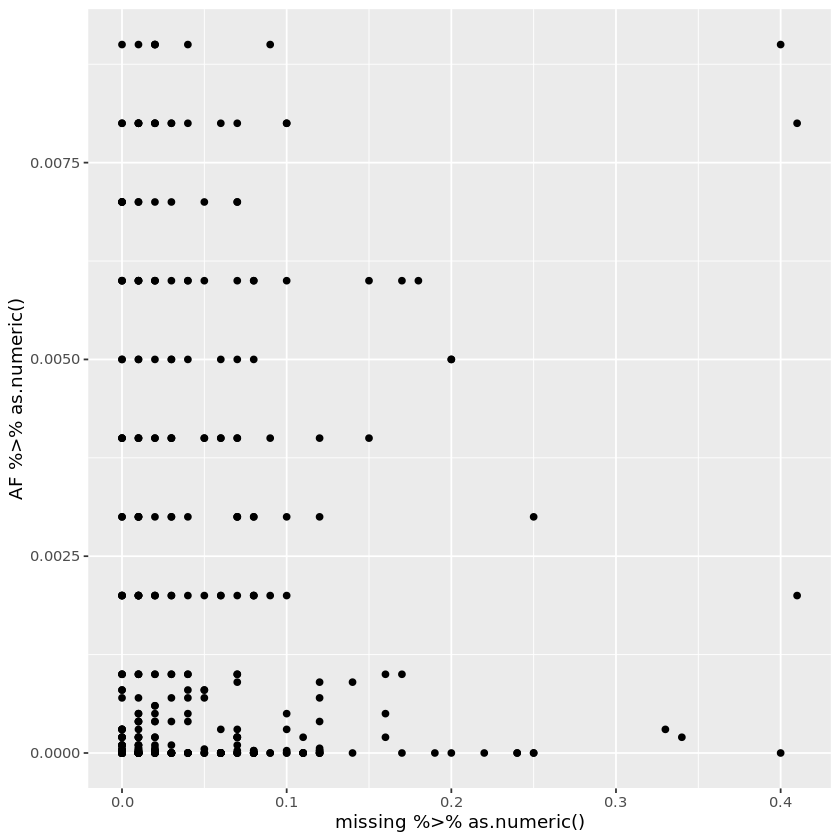

In [17]:
ggplot(var_maf_outlier_result_cl[var_maf_outlier_result_cl$cellline_names =="A498",], aes(missing %>% as.numeric(),AF %>% as.numeric()))+
  geom_point()